In [ ]:
!pip install pyupbit

     |████████████████████████████████| 81kB 9.3MB/s 


In [ ]:
import pyupbit
import pandas as pd
import time
import numpy as np

class My_Upbit_Data():
    
    def __init__(self,coinid='ZRX'):
        
        self.coinid = coinid

    def __load_data(self, interval='minute10', date=None, rows=1000):
        dfs = []
        
        ranges = int(rows/200)
        
        for i in range(ranges):
            df = pyupbit.get_ohlcv(ticker='KRW-'+self.coinid, interval=interval, to=date)
            dfs.append(df)

            date = df.index[0]
            time.sleep(0.15)

        df = pd.concat(dfs).sort_index()
        
        return df
    
    def load_ml_data(self,col='open',interval='minute10',rows=20000):
        dataframe = self.__load_data(interval=interval, rows=rows)
        times = dataframe.index

        return [times,dataframe]

In [322]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#plt.rcParams['font.family'] = 'Malgun Gothic'

class My_Lstm:
    def windowed_dataset(self, series, window_size, batch_size, shuffle_buffer):
        series = tf.expand_dims(series, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size + 1))
        ds = ds.shuffle(shuffle_buffer)
        ds = ds.map(lambda w: (w[:-1], w[1:]))

        return ds.batch(batch_size).prefetch(1)

    def __dataframe_to_series(self, dataframe, col='open'):
        data = dataframe

        return np.asarray(data[col], dtype='float32')

    def scale_data_fit(self, series):
        self.min_scale = np.min(series)
        self.max_scale = np.max(series)

    def scale_data(self, series):
        series = np.array(series)
        series -= self.min_scale
        series /= self.max_scale

        return series

    def un_scale_data(self, series):
        series = np.array(series)
        series *= self.max_scale
        series += self.min_scale

        return series

    def keras_layers_compile(self, loss='mae', optimizer='adam', metrics='mae'):
        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, input_shape=[None, 1], return_sequences=True),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(1)])

        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def callbacks(self, monitor='loss', mode='min', patience=10):
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 10))
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='mse', patience=10)
        return [lr_schedule, earlystop]

    def fit_lstm(self, dataset, epochs=100, callbacks=None):
        if callbacks:
            history = self.model.fit(dataset, epochs=epochs, callbacks=callbacks)
        else:
            history = self.model.fit(dataset, epochs=epochs)
        return history

    def train_data_load(self, dataframe, col='open', scale=True, train_mode=True, window_size=24, batch_size=16,
                        shuffle_buffer=30000):
        self.scale = scale

        # Dataframe to series 하나의 컬럼만 가져와서 예측진행
        series = self.__dataframe_to_series(dataframe, col=col)
        self.times = dataframe.index

        # 원본데이터 백업
        self.backup_series = series

        # Scale 진행 MinMax scale

        if train_mode:
            if self.scale:
                self.scale_data_fit(series)
                series = self.scale_data(series)
        else:
            if self.scale:
                self.scale_data_fit(series)

        # Tensorflow 전용 데이터셋으로 변환 (window size=예측할 날짜수)
        self.window_size = window_size

        if train_mode:
            series = self.windowed_dataset(series, self.window_size, batch_size, shuffle_buffer)

            self.series = series
        else:
            self.series = series

    def train_lstm(self, epochs=100, callbacks=None, loss='mae', optimizer='adam', metrics='mae'):

        # Keras
        self.keras_layers_compile(loss=loss, optimizer=optimizer, metrics=metrics)
        if callbacks:
            callbacks = self.callbacks()
        else:

            pass
        history = self.fit_lstm(self.series, epochs=epochs, callbacks=callbacks)

        return history

    def save_md(self, name):
        try:
            self.model.save(name)
        except:
            print('Error!')

    def model_load(self, name, compile=True):
        if compile:
            self.keras_layers_compile()
            self.model = tf.keras.models.load_model(name)
        else:
            self.model = tf.keras.models.load_model(name)

    def predict(self, times, ranges=[0, 200]):
        predicts = []
        self.ranges = ranges
        # self.backup_series_to_un_scale = self.un_scale_data(self.backup_series[ranges[0]:ranges[1]])

        self.time_series = times[ranges[0]:ranges[1]]

        ranges_series = self.backup_series[ranges[0]:ranges[1]]

        if self.scale:

            ranges_series_scale = self.scale_data(ranges_series)

            for time in range(len(ranges_series_scale) - self.window_size):
                pred = np.array(ranges_series_scale[time: time + self.window_size])

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                predicts.append(predict[0][0])
            # 수정부분
            predicts = self.un_scale_data(predicts)
        else:

            for time in range(len(ranges_series) - self.window_size):
                pred = np.array(ranges_series[time: time + self.window_size])

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                predicts.append(predict[0][0])

        return predicts

    def predict_plot(self, predicts):

        plt.figure(figsize=(12, 8))
        plt.plot(self.time_series[:-self.window_size], predicts, color='red', label='Predict')
        plt.plot(self.time_series[:-self.window_size],
                 self.backup_series[self.ranges[0]:self.ranges[1] - self.window_size], color='blue', label='Real')
        plt.legend(loc='center left')
        plt.show()

    def predict_last_few(self, future_):
        
        _last_future_series = self.backup_series[-self.window_size:]
        
        self.future_ = future_
        futures = []

        if self.scale:

            _last_future_series = self.scale_data(_last_future_series)

            for time in range(future_):
                pred = np.array(_last_future_series, dtype='float64')

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                _last_future_series = np.append(_last_future_series, predict[0][0])

                futures.append(predict[0][0])

                _last_future_series = np.delete(_last_future_series, 0)

            futures = self.un_scale_data(futures)
            _last_future_series = self.un_scale_data(_last_future_series)

        else:

            for time in range(future_):
                pred = np.array(_last_future_series, dtype='float64')

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                _last_future_series = np.append(_last_future_series, predict[0][0])
                futures.append(predict[0][0])

                _last_future_series = np.delete(_last_future_series, 0)

        self.futures = futures
        self._last_future_series =_last_future_series

    def plot_few_(self,):
        threshold = np.ones_like(self._last_future_series,dtype=bool)
        threshold[:-self.future_] = False

        pred_x = self.times[-self.window_size:]
        pred_y = self._last_future_series

        plt.plot(pred_x, pred_y,color='blue', label='Real')
        plt.plot(pred_x[threshold], pred_y[threshold], color='red', label='Real')
        plt.title('{}개의 예측결과'.format(self.future_))
        plt.show()

# Train


In [334]:
mylstm = My_Lstm()

In [335]:
mud = My_Upbit_Data(coinid='ZRX')

In [336]:
times, data = mud.load_ml_data(col='open', interval='minute10', rows=30000)

In [337]:
mylstm.train_data_load(data,scale=True,train_mode=True,window_size=24,batch_size=8,shuffle_buffer=50000)

In [ ]:
mylstm.train_lstm(loss='mse',metrics='mse',epochs=100,callbacks='go',)

Epoch 1/100
3747/3747 [==============================] - 37s 9ms/step - loss: 0.1826 - mse: 0.1826
Epoch 2/100
3747/3747 [==============================] - 34s 9ms/step - loss: 0.1194 - mse: 0.1194
Epoch 3/100
3666/3747 [============================>.] - ETA: 0s - loss: 0.0773 - mse: 0.0773

In [ ]:
pred1 = mylstm.predict(times,ranges=[19000,20000])

In [ ]:
mylstm.predict_plot(pred1)

In [ ]:
mylstm.save_md('ZRX_winsize24_epoch100_batch8.h5')

#Test

In [323]:
mylstm2 = My_Lstm()

In [324]:
mylstm2.model_load('ZRX_winsize24_epoch100_batch8.h5',compile=False)
#mylstm2.model.compile(loss='mae', optimizer='adam', metrics='mae')

In [326]:
mylstm2.train_data_load(data,scale=True,train_mode=False)

In [329]:
mylstm2.predict_last_few(5)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_

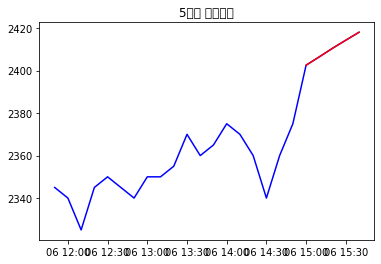

In [330]:
mylstm2.plot_few_()

In [ ]:
print(f"RMSE : {np.sqrt(mean_squared_error(real,pred))}")

34.111183

In [ ]:
print(f"RMSLE : {np.sqrt(mean_squared_error(np.log(real-1),np.log(pred-1)))}")

RMSLE : 0.015429836697876453
